# Variational Autoencoder: Train Model

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import axis, colorbar, imshow, show, figure, subplot
from matplotlib import cm
import matplotlib as mpl
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
%matplotlib inline

import glob

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

from time import time
from tqdm import tqdm

import cv2

import sklearn
from sklearn.model_selection import train_test_split

## ----- GPU ------------------------------------
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'    # use of GPU 0 (ERDA) (use before importing torch or tensorflow/keeas)
## ----------------------------------------------

import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras.activations import relu
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K                         #contains calls for tensor manipulations

In [2]:
print (tf.__version__)
print (keras.__version__)

2.3.0
2.4.3


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Initializing

In [4]:
from utils_vae_potato_paths import *

# Get work directions for augmentated data set:
print ("NORMAL_TRAIN_AUG:      ", NORMAL_TRAIN_AUG)
print ("NORMAL_VALIDATION_AUG: ", NORMAL_VAL_AUG)
print ("NORMAL_TEST_AUG:       ", NORMAL_TEST_AUG)
print ("ANOMALY1_AUG:          ", ANOMALY1_AUG)
print ("ANOMALY2_AUG:          ", ANOMALY2_AUG)

NORMAL_TRAIN_AUG:       /home/jovyan/work/Speciale/FoodSorting/generated_dataset/Potato//DataAugmentation/NormalTrainAugmentations
NORMAL_VALIDATION_AUG:  /home/jovyan/work/Speciale/FoodSorting/generated_dataset/Potato//DataAugmentation/NormalValidationAugmentations
NORMAL_TEST_AUG:        /home/jovyan/work/Speciale/FoodSorting/generated_dataset/Potato//DataAugmentation/NormalTestAugmentations
ANOMALY1_AUG:           /home/jovyan/work/Speciale/FoodSorting/generated_dataset/Potato//DataAugmentation/Anomaly1Augmentations
ANOMALY2_AUG:           /home/jovyan/work/Speciale/FoodSorting/generated_dataset/Potato//DataAugmentation/Anomaly2Augmentations


In [5]:
# What latent dimension and filter size are we using?:
latent_dim = 16
filters    = 32

# Get work direction for saving files:
SAVE_FOLDER = f'saved_models/latent{latent_dim}'
print ("Which Folder The Models Are Saved In:", SAVE_FOLDER)

Which Folder The Models Are Saved In: saved_models/latent16


In [6]:
# Delete all existing files in folder where models are saved:
print("[INFO] deleting existing files in folder...")
t0 = time()

files = glob.glob(f'{SAVE_FOLDER}/*')
for f in files:
    os.remove(f)

print ("         done in %0.3f minutes" % ((time() - t0)/60))

[INFO] deleting existing files in folder...
         done in 0.003 minutes


## Load Data


### Import Utils

In [7]:
from utils_VAE_AE import get_labels

### Quick Investigation of Ground Truths

In [8]:
# Glob the directories and get the lists of good and bad images
good_train_fns = [f for f in os.listdir(NORMAL_TRAIN_AUG) if not f.startswith('.')]
good_val_fns = [f for f in os.listdir(NORMAL_VAL_AUG) if not f.startswith('.')]
good_test_fns = [f for f in os.listdir(NORMAL_TEST_AUG) if not f.startswith('.')]
bad1_fns = [f for f in os.listdir(ANOMALY1_AUG) if not f.startswith('.')]
bad2_fns = [f for f in os.listdir(ANOMALY2_AUG) if not f.startswith('.')]

print('Number of "normal" training images is:     {}'.format(len(good_train_fns)))
print('Number of "normal" validation images is:   {}'.format(len(good_val_fns)))
print('Number of "normal" test images is:         {}'.format(len(good_test_fns)))
print('Total number of "anomaly" images is:       {}'.format(len(bad1_fns) + len(bad2_fns)))

Number of "normal" training images is:     1639
Number of "normal" validation images is:   80
Number of "normal" test images is:         320
Total number of "anomaly" images is:       680


In [9]:
# compute procentage of bad images vs good images:
normal_fns = len(good_train_fns) + len(good_val_fns) + len(good_test_fns)
anomaly_fns = len(bad1_fns + bad2_fns)
print(f"> Procentage of normal samples (ground truth):   {(normal_fns / (normal_fns + anomaly_fns)) * 100:.2f} %")
print(f"> Procentage of anomaly samples (ground truth):  {(anomaly_fns / (normal_fns + anomaly_fns)) * 100:.2f} %")

> Procentage of normal samples (ground truth):   74.99 %
> Procentage of anomaly samples (ground truth):  25.01 %


### Load Normal Data

Load normal samples in pre-splitted data sets: train, valdiation and test.


In [10]:
print("[INFO] loading normal training images...")
trainX = [cv2.imread(file, 0) for file in glob.glob(f"{NORMAL_TRAIN_AUG}/*.png")]  # read as grayscale
trainX = np.array(trainX)
print("          done")

# create a corresponding list of labels:
trainY = get_labels(trainX, 0)

[INFO] loading normal training images...
          done


In [11]:
print("[INFO] loading normal validation images...")
x_normal_val = [cv2.imread(file, 0) for file in glob.glob(f"{NORMAL_VAL_AUG}/*.png")]  # read as grayscale
x_normal_val = np.array(x_normal_val)
print("          done")

# create a corresponding list of labels:
y_normal_val = get_labels(x_normal_val, 0)

[INFO] loading normal validation images...
          done


In [12]:
print("[INFO] loading normal testing images...")
x_normal_test = [cv2.imread(file, 0) for file in glob.glob(f"{NORMAL_TEST_AUG}/*.png")]  # read as grayscale
x_normal_test = np.array(x_normal_test)
print("          done")

# create a corresponding list of labels:
y_normal_test = get_labels(x_normal_test, 0)

[INFO] loading normal testing images...
          done


### Load Anomaly Class 1 Data (i.e. 'metal' sampels)

In [13]:
print("[INFO] loading anomaly class 1 ('metal') images...")
x_metal = [cv2.imread(file, 0) for file in glob.glob(f"{ANOMALY1_AUG}/*.png")]  # read as grayscale
x_metal = np.array(x_metal)
print("          done")

# create a corresponding list of labels:
y_metal = get_labels(x_metal, 1)

[INFO] loading anomaly class 1 ('metal') images...
          done


### Load Anomaly Class 2 Data (i.e. 'hollow' sampels)

In [14]:
print("[INFO] loading anomaly class 2 ('hollow') images...")
x_hollow = [cv2.imread(file, 0) for file in glob.glob(f"{ANOMALY2_AUG}/*.png")]  # read as grayscale
x_hollow = np.array(x_hollow)
print("          done")

# create a corresponding list of labels:
y_hollow = get_labels(x_hollow, 2)

[INFO] loading anomaly class 2 ('hollow') images...
          done


### Combine normal samples and anomaly samples and split them into training, validation and test sets


`label 0` == Normal Samples (=> Perfect' Samples)

`label 1` == Anomaly 1 Samples (=> 'Metal' Samples)

`label 2` == Anomaly 2 Samples (=> 'Hollow' Samples)

Train and Validation sets only consists of `Normal Data`, aka. `label 0`.


In [15]:
# combine pre-loaded validation and testing set into a new testing set:
testvalX = np.vstack((x_normal_val, x_normal_test))
testvalY = get_labels(testvalX, 0)

# randomly split in order to make new validation set:
NoUsageX, valX, NoUsageY, valY = train_test_split(testvalX, testvalY, test_size=0.25, random_state=4345672)

In [16]:
""" Testing set """
# combine pre-loaded validation and testing set into a new testing set:
testNormalX = np.vstack((x_normal_val, x_normal_test))
testNormalY = get_labels(testNormalX, 0)

# Anomaly Class 1 (i.e. 'metal' samples):
testAnomaly1X, testAnomaly1Y = x_metal, y_metal

# Anomaly Class 2 (i.e. 'hollow' samples):
testAnomaly2X, testAnomaly2Y = x_hollow, y_hollow

# Combine all testing data in one array (the test set is NOT used during any part but inference):
testAllX = np.vstack((testNormalX, testAnomaly1X, testAnomaly2X))
testAllY = np.hstack((testNormalY, testAnomaly1Y, testAnomaly2Y))

## Check Data Dimensions and Distributions


### Inspect data shapes

In [17]:
print("Training set:")
print(" > images:", trainX.shape)
print(" > labels:", trainY.shape)
print ("")

print("Validation set:")
print(" > images:", valX.shape)
print(" > labels:", valY.shape)
print ("")

print("Test set:")
print(" > images:", testAllX.shape)
print(" > labels:", testAllY.shape)
print("\t'Normal' test set:")
print("\t  > images:", testNormalX.shape)
print("\t  > labels:", testNormalY.shape)
print("\t'Anomaly 1' test set:")
print("\t  > images:", testAnomaly1X.shape)
print("\t  > labels:", testAnomaly1Y.shape)
print("\t'Anomaly 2' test set:")
print("\t  > images:", testAnomaly2X.shape)
print("\t  > labels:", testAnomaly2Y.shape)

Training set:
 > images: (1639, 128, 128)
 > labels: (1639,)

Validation set:
 > images: (100, 128, 128)
 > labels: (100,)

Test set:
 > images: (1080, 128, 128)
 > labels: (1080,)
	'Normal' test set:
	  > images: (400, 128, 128)
	  > labels: (400,)
	'Anomaly 1' test set:
	  > images: (392, 128, 128)
	  > labels: (392,)
	'Anomaly 2' test set:
	  > images: (288, 128, 128)
	  > labels: (288,)


In [18]:
# compute procentage between training, validation and test data sets (only normal data):
print(f"Procentage of training samples: {(len(trainX) / (len(trainX) + len(valX) + len(testNormalX))) * 100:.2f} %")
print(f"Procentage of validation samples: {(len(valX) / (len(trainX) + len(valX) + len(testNormalX))) * 100:.2f} %")
print(f"Procentage of (only normal) testing samples: {(len(testNormalX) / (len(trainX) + len(valX) + len(testNormalX))) * 100:.2f} %")

Procentage of training samples: 76.62 %
Procentage of validation samples: 4.68 %
Procentage of (only normal) testing samples: 18.70 %


In [19]:
# compute procentage between training, validation and test data sets:
print(f"Procentage of training samples: {(len(trainX) / (len(trainX) + len(valX) + len(testAllX))) * 100:.2f} %")
print(f"Procentage of validation samples: {(len(valX) / (len(trainX) + len(valX) + len(testAllX))) * 100:.2f} %")
print(f"Procentage of (total) testing samples: {(len(testAllX) / (len(trainX) + len(valX) + len(testAllX))) * 100:.2f} %")

Procentage of training samples: 58.14 %
Procentage of validation samples: 3.55 %
Procentage of (total) testing samples: 38.31 %


### Check for (un)balanced data



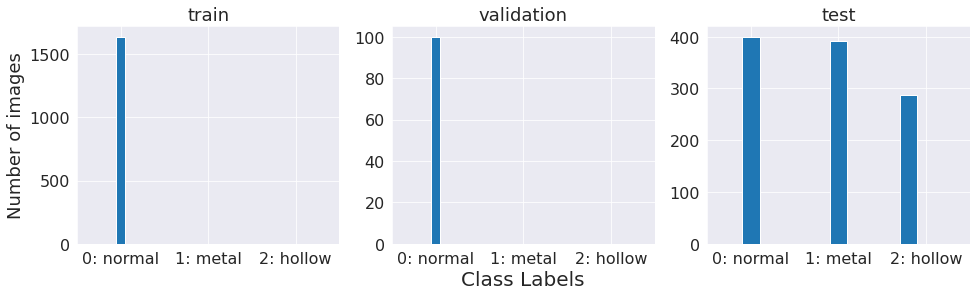

In [20]:
labels = ['0: normal', '1: metal', '2: hollow']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(trainY, align="left"); ax[0].set_title('train', fontsize=18); ax[0].set_xticks([0,1,2]); ax[0].set_xticklabels(labels); ax[0].tick_params(axis='both', which='major', labelsize=16); ax[0].set_xlim(-0.5, 2.5);
ax[1].hist(valY, align="left"); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks([0,1,2]); ax[1].set_xticklabels(labels); ax[1].tick_params(axis='both', which='major', labelsize=16); ax[1].set_xlim(-0.5, 2.5);
ax[2].hist(testAllY, align="left"); ax[2].set_title('test', fontsize=18); ax[2].set_xticks([0,1,2]); ax[2].set_xticklabels(labels); ax[2].tick_params(axis='both', which='major', labelsize=16); ax[2].set_xlim(-0.5, 2.5);

ax[0].set_ylabel("Number of images", fontsize=18)
ax[1].set_xlabel("Class Labels", fontsize=20)
plt.show()

In [21]:
# compute procentage of normal test images vs total anomaly test images:
print(f"Procentage of normal test samples: {(len(testNormalX) / (len(testNormalX) + (len(testAnomaly1X) + len(testAnomaly2X)))) * 100:.2f} %")
print(f"Procentage of total anomaly test samples: {((len(testAnomaly1X) + len(testAnomaly2X)) / (len(testNormalX) + (len(testAnomaly1X) + len(testAnomaly2X)))) * 100:.2f} %")

Procentage of normal test samples: 37.04 %
Procentage of total anomaly test samples: 62.96 %


## Feature Scaling

Only normalization has been used.

In [22]:
# Data configuration
img_width, img_height = trainX.shape[1], trainX.shape[2]      # input image dimensions
num_channels = 1                                              # gray-channel

### Normalization

Neural Networks learns faster with normalized data.

In [23]:
# Normalize to be in  the [0, 1] range:
trainX = trainX.astype('float32') / 255.
valX = valX.astype('float32') / 255.
testAllX = testAllX.astype('float32') / 255.

# reshape data to keras inputs --> (n_samples, img_rows, img_cols, n_channels):
trainX = trainX.reshape(trainX.shape[0], img_height, img_width, num_channels)
valX = valX.reshape(valX.shape[0], img_height, img_width, num_channels)
testAllX = testAllX.reshape(testAllX.shape[0], img_height, img_width, num_channels)

# Train the VAE

## Architecture and Hyperparameters

In [24]:
# import architecture of VAE model and its hyperparameters:
from J16_VAE_model import *

### *Encoder Part*


In [25]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        leaky_re_lu[0][0]                
____________________________________________________________________________________________

### *Decoder Part*

In [26]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 512)               8704      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          9248      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        9248      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0   

### *Total VAE Model*

In [27]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 16), (None, 16),  146344    
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 1)       55233     
Total params: 201,577
Trainable params: 201,577
Non-trainable params: 0
_________________________________________________________________


## Compile and train model


In [28]:
""" Hyperparameters """
batch_size  = 256
epochs      = 2000

### Keras Callbacks

In [29]:
"""
Checkpoint callback options: save model at 1'st epoch (inital model)

https://stackoverflow.com/questions/54323960/save-keras-model-at-specific-epochs
"""

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 1:
            self.model.save_weights(f"{SAVE_FOLDER}/cp-0001.h5")
            
# create and use callback:
initial_checkpoint = CustomSaver()

In [30]:
"""
Checkpoint callback options: save model at every k'te epochs
"""
# Include the epoch in the file name (uses `str.format`):
checkpoint_path = "saved_models/latent16/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every k'te epochs:
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             monitor='loss',           # name of the metrics to monitor
                             verbose=1, 
                             #save_best_only=False,     # if False, the best model will not be overridden.
                             save_weights_only=True,   # if True, only the weights of the models will be saved.
                                                        # if False, the whole models will be saved.
                             #mode='auto', 
                             period=200                  # save after every k'te epochs
                            )

# Save the weights using the `checkpoint_path` format
vae.save_weights(checkpoint_path.format(epoch=0))          # save for zero epoch (inital)

In [31]:
"""
Checkpoint callback options: Early stopping
https://www.tensorflow.org/guide/keras/custom_callback
"""

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=100):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

### Compile and train model

In [32]:
""" Create and Compile Model"""
# import architecture of VAE model and its hyperparameters. learning rate choosen from graph above.
vae = create_model()

In [33]:
""" Train VAE model with callbacks """
history = vae.fit(trainX, trainX, 
                  batch_size = batch_size, 
                  epochs = epochs, 
                  callbacks=[initial_checkpoint, checkpoint, EarlyStoppingAtMinLoss()],
                  #callbacks=[initial_checkpoint, checkpoint],
                  shuffle=True,
                  validation_data=(valX, valX)
                 )

Epoch 1/2000
7/7 [==============================] - 1s 195ms/step - loss: 2323.1711 - val_loss: 2256.1541
Epoch 2/2000
7/7 [==============================] - 1s 106ms/step - loss: 2093.8936 - val_loss: 1765.4158
Epoch 3/2000
7/7 [==============================] - 1s 106ms/step - loss: 1459.6526 - val_loss: 1227.4159
Epoch 4/2000
7/7 [==============================] - 1s 106ms/step - loss: 1036.5129 - val_loss: 836.0411
Epoch 5/2000
7/7 [==============================] - 1s 106ms/step - loss: 730.8901 - val_loss: 616.3928
Epoch 6/2000
7/7 [==============================] - 1s 106ms/step - loss: 535.5724 - val_loss: 465.8549
Epoch 7/2000
7/7 [==============================] - 1s 106ms/step - loss: 428.4212 - val_loss: 394.7655
Epoch 8/2000
7/7 [==============================] - 1s 106ms/step - loss: 377.9353 - val_loss: 365.8254
Epoch 9/2000
7/7 [==============================] - 1s 106ms/step - loss: 351.9335 - val_loss: 344.1267
Epoch 10/2000
7/7 [==============================] - 1s 1

In [34]:
# In this GPU implementation, it shows the number of batches/iterations for one epoch (and not the training samples), which is:
print ("Step size:", np.ceil(trainX.shape[0]/batch_size))

Step size: 7.0


In [35]:
""" Save the entire model """
# Save notes about hyperparameters used:
epochs = len(history.history['loss'])
with open(f'{SAVE_FOLDER}/notes.txt', 'w') as f:
    f.write(f'Epochs: {epochs} \n')
    f.write(f'Batch size: {batch_size} \n')
    f.write(f'Latent dimension: {latent_dim} \n')
    f.write(f'Filter sizes: {filters} \n')
    f.write(f'img_width: {img_width} \n')
    f.write(f'img_height: {img_height} \n')
    f.write(f'num_channels: {num_channels}')
    f.close()

# Save weights for encoder model:
encoder.save_weights(f'{SAVE_FOLDER}/ENCODER_WEIGHTS.h5')

# Save weights for decoder model:
decoder.save_weights(f'{SAVE_FOLDER}/DECODER_WEIGHTS.h5')

# Save weights for total VAE:
vae.save_weights(f'{SAVE_FOLDER}/VAE_WEIGHTS.h5')

# Save the history at each epochs (cost of train and validation sets):
np.save(f'{SAVE_FOLDER}/HISTORY.npy', history.history)

# Save exact training, validation and testing data set (as numpy arrays):
np.save(f'{SAVE_FOLDER}/trainX.npy', trainX)
np.save(f'{SAVE_FOLDER}/valX.npy', valX)
np.save(f'{SAVE_FOLDER}/testAllX.npy', testAllX)
np.save(f'{SAVE_FOLDER}/testAllY.npy', testAllY)

## Evaluate training process

Now that the training process is complete, let’s evaluate the average loss of the model

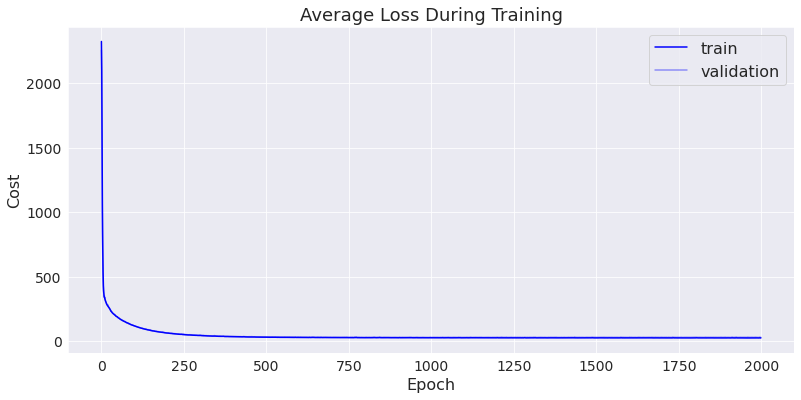

In [36]:
sns.set_style("darkgrid")
plt.figure(figsize=(13, 6))

# summarize history for loss:
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='blue', alpha=0.4, label='validation')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Average Loss During Training', fontsize=18)
#plt.xticks(range(0,epochs))
plt.legend(loc='upper right', fontsize=16)
plt.show()